<img src="https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/imagens/logo_nlportugues.png"   width="150" align="right">


# Lista 6 - LSTM & GRU 


______________



O objetivo desta lista é fazer com que vocês treinem um modelo de análise de sentimentos utilizando GRU's e LSTM's. Essa lista é semelhante a lista 03 onde aprendemos a usar embeddings e onde você ja recebeu a arquitetura do seu modelo quase pronta. A diferença é que desta vez você ira construir sozinho sua rede e utilizará as camadas que acabamos de aprender: LSTM e GRU.

In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [33]:
tf.__version__

'2.17.0'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [34]:
!mkdir data

mkdir: data: File exists


In [35]:
!curl https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/Semana%2003/data/b2w-10k.csv --output 'data/b2w-10k.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3919k  100 3919k    0     0  4489k      0 --:--:-- --:--:-- --:--:-- 4489k


In [36]:
b2wCorpus = pd.read_csv("data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [37]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


## Pré-processamento 
# <font color='blue'>Questão 1 </font>
Copie suas etapas de préprocessamento da lista 03, ou seja, selecione apenas as colunas relevantes ("review_text" e "recommend_to_a_friend"), converta a coluna "review_text" de uma coluna de `str` para uma coluna de `int` e separe os dados em teste e treino.


In [38]:
b2wCorpus['recommend_to_a_friend'] = (b2wCorpus['recommend_to_a_friend'] == "Yes").astype(int) # Seu código aqui
novo_lwt = b2wCorpus[b2wCorpus['reviewer_gender'].isin(['M', 'F'])]
novo_lwt = novo_lwt[["review_text", "recommend_to_a_friend"]]
novo_lwt.loc[novo_lwt['recommend_to_a_friend'] == "Yes", 'recommend_to_a_friend'] = "1"
novo_lwt.loc[novo_lwt['recommend_to_a_friend'] == "No", 'recommend_to_a_friend'] = "0"
novo_lwt["recommend_to_a_friend"] = novo_lwt["recommend_to_a_friend"].astype(int)
review = novo_lwt['review_text']
labels = novo_lwt['recommend_to_a_friend']

train_review, test_review, train_labels, test_labels = train_test_split(
    review, labels, test_size=0.2, random_state=42
)

/var/folders/m2/t9xgwjd522g9rwj15_vlxhlr0000gn/T/ipykernel_65543/543381043.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  novo_lwt.loc[novo_lwt['recommend_to_a_friend'] == "Yes", 'recommend_to_a_friend'] = "1"


In [43]:
test_labels

3717    0
9068    1
3302    1
4092    1
3913    0
       ..
1942    1
6457    1
9691    0
7929    1
9634    1
Name: recommend_to_a_friend, Length: 1932, dtype: int64

## Tokenizando




# <font color='blue'>Questão 2 </font>
Utilizando a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) tokenize os inputs.
Declare a camada e então chame a função `adapt()` no seu conjunto de treino para adequar o seu vocabulário aos reviews. 

Note que o uso de padding não é mais necessario.

In [65]:
max_tokens = 20000
output_sequence_length = 100
embedding_dim = 128

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int', 
    output_sequence_length=output_sequence_length,
)
vectorizer.adapt(train_review)
train_tokens = vectorizer(train_review)
test_tokens = vectorizer(test_review)

## LSTM&GRU

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

#  <font color='blue'>Questão 3 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas  [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?




**<font color='red'> Sua resposta aqui </font>**

In [76]:
max_tokens = 20000
output_sequence_length = 100
embedding_dim = 128

# Definir o modelo
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,  # Camada de tokenização
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.LSTM(128, return_sequences=False),  # Camada LSTM substituindo a GRU
    layers.Dense(128, activation='relu'),      # Camada densa totalmente conectada
    layers.Dropout(0.5),                       # Camada Dropout para prevenir overfitting
    layers.Dense(1, activation='sigmoid')      # Camada de saída com ativação sigmoide
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_12           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_15 (Embedding)        │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,708,225 (10.33 MB)

 Trainable params: 2,708,225 (10.33 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Treinar o modelo
history = model.fit(
    train_review,       # Dados de entrada de treinamento (brutos, como strings)
    train_labels,       # Rótulos correspondentes aos dados de treinamento
    epochs=10,          # Número de épocas (pode ajustar conforme necessário)
    batch_size=32,      # Tamanho do lote (pode ajustar conforme necessário)
    validation_data=(test_review, test_labels),  # Dados de validação (brutos, como strings)
    verbose=1           # Nível de verbosidade (1 para ver o progresso do treinamento)
)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.7463 - loss: 0.5760 - val_accuracy: 0.7495 - val_loss: 0.5622
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.7620 - loss: 0.5550 - val_accuracy: 0.7505 - val_loss: 0.5723
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7589 - loss: 0.5595 - val_accuracy: 0.7500 - val_loss: 0.5668
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.7583 - loss: 0.5554 - val_accuracy: 0.7640 - val_loss: 0.5923
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.7591 - loss: 0.5586 - val_accuracy: 0.7510 - val_loss: 0.5691
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.7517 - loss: 0.5629 - val_accuracy: 0.7516 - val_loss: 0.5673
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.7643 - loss: 0.5448 - val_accuracy: 0.8602 - val_loss: 0.3586
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step - accuracy: 0.8757 - loss: 0.3186 -

In [78]:
test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8954 - loss: 0.3124
Loss no conjunto de teste: 0.3260
Acurácia no conjunto de teste: 89.1304%


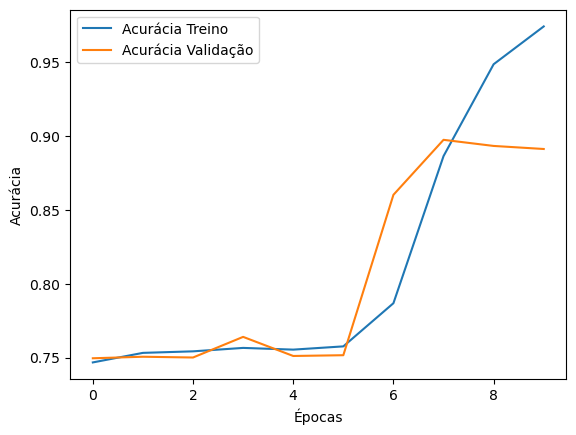

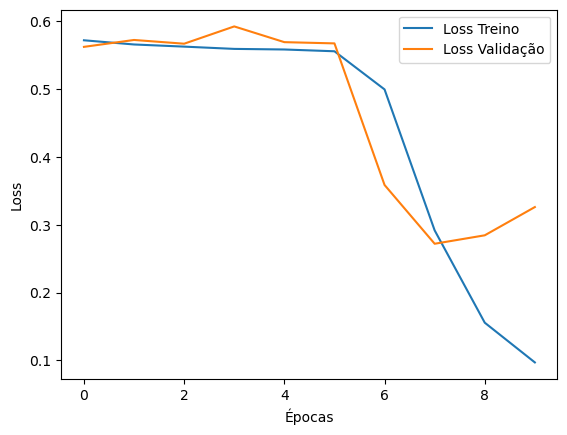

In [79]:
# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar o loss
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  <font color='blue'>Questão 4 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas [GRU](https://keras.io/api/layers/recurrent_layers/gru/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?


**<font color='red'> Sua resposta aqui </font>**

In [80]:
max_tokens = 20000
output_sequence_length = 100
embedding_dim = 128

# Definir o modelo
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,  # Camada de tokenização
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.GRU(128, return_sequences=False),  # Camada GRU
    layers.Dense(128, activation='relu'),     # Camada densa totalmente conectada
    layers.Dropout(0.5),                      # Camada Dropout para prevenir overfitting
    layers.Dense(1, activation='sigmoid')     # Camada de saída com ativação sigmoide
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_12           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_16 (Embedding)        │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,675,713 (10.21 MB)

 Trainable params: 2,675,713 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Treinar o modelo
history = model.fit(
    train_review,       # Dados de entrada de treinamento (brutos, como strings)
    train_labels,       # Rótulos correspondentes aos dados de treinamento
    epochs=10,          # Número de épocas (pode ajustar conforme necessário)
    batch_size=32,      # Tamanho do lote (pode ajustar conforme necessário)
    validation_data=(test_review, test_labels),  # Dados de validação (brutos, como strings)
    verbose=1           # Nível de verbosidade (1 para ver o progresso do treinamento)
)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.7459 - loss: 0.5806 - val_accuracy: 0.7484 - val_loss: 0.5632
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.7531 - loss: 0.5681 - val_accuracy: 0.7495 - val_loss: 0.5664
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.7570 - loss: 0.5580 - val_accuracy: 0.7484 - val_loss: 0.5575
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.8020 - loss: 0.4249 - val_accuracy: 0.9058 - val_loss: 0.2581
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9415 - loss: 0.1852 - val_accuracy: 0.8846 - val_loss: 0.2929
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9750 - loss: 0.1001 - val_accuracy: 0.8825 - val_loss: 0.3770
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9888 - loss: 0.0439 - val_accuracy: 0.8773 - val_loss: 0.3917
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9942 - loss: 0.0307 - 

In [82]:
test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8794 - loss: 0.6884
Loss no conjunto de teste: 0.7013
Acurácia no conjunto de teste: 87.4741%


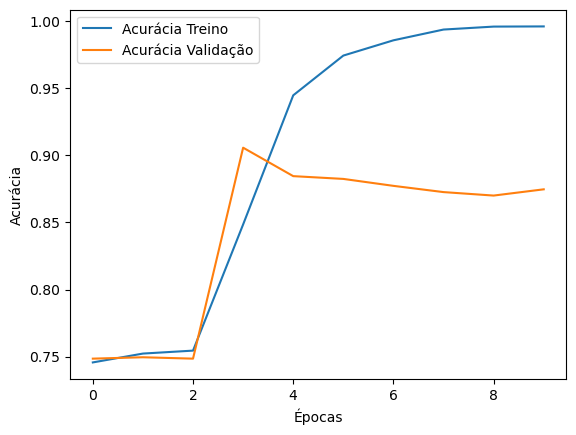

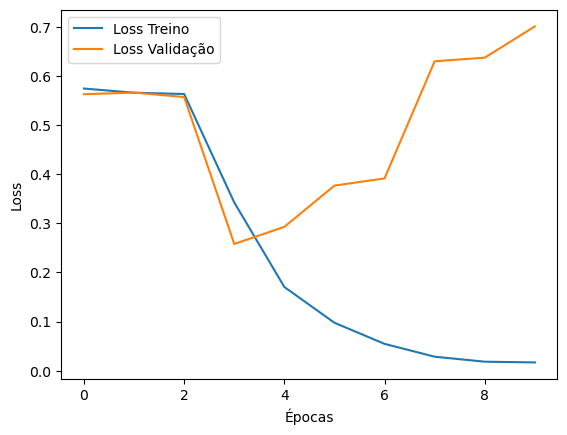

In [83]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar o loss
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Redes Bi-direcionais
#  <font color='blue'>Questão 5 </font>

a) Defina, compile, treine e avalie um novo modelo que utilize contexto em ambas as direções usando a camada [`Bidirectional()`](https://keras.io/api/layers/recurrent_layers/bidirectional/), seja com camadas GRU ou LSTM.


b) Como foi sua performance em relação as questões anteriores com contexto unidirecional?

**<font color='red'> Sua resposta aqui </font>**

In [98]:
max_tokens = 15000
output_sequence_length = 200
embedding_dim = 128

# Definir o modelo
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,  # Camada de tokenização
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),  # LSTM Bidirecional
    layers.Dense(128, activation='relu'),                            # Camada densa totalmente conectada
    layers.Dropout(0.5),                                             # Camada Dropout para prevenir overfitting
    layers.Dense(1, activation='sigmoid')                            # Camada de saída com ativação sigmoide
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_12           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_23 (Embedding)        │ (None, 100, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,216,193 (8.45 MB)

 Trainable params: 2,216,193 (8.45 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,  # Camada de tokenização
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=output_sequence_length),
    
    layers.Bidirectional(layers.GRU(128, return_sequences=False)),  # GRU Bidirecional
    layers.Dense(128, activation='relu'),                            # Camada densa totalmente conectada
    layers.Dropout(0.5),                                             # Camada Dropout para prevenir overfitting
    layers.Dense(1, activation='sigmoid')                            # Camada de saída com ativação sigmoide
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_12           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_24 (Embedding)        │ (None, 100, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,151,169 (8.21 MB)

 Trainable params: 2,151,169 (8.21 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Treinar o modelo
history = model.fit(
    train_review,       # Dados de entrada de treinamento (brutos, como strings)
    train_labels,       # Rótulos correspondentes aos dados de treinamento
    epochs=10,          # Número de épocas (pode ajustar conforme necessário)
    batch_size=32,      # Tamanho do lote (pode ajustar conforme necessário)
    validation_data=(test_review, test_labels),  # Dados de validação (brutos, como strings)
    verbose=1           # Nível de verbosidade (1 para ver o progresso do treinamento)
)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.7894 - loss: 0.4418 - val_accuracy: 0.8882 - val_loss: 0.2702
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.9286 - loss: 0.1983 - val_accuracy: 0.8934 - val_loss: 0.2763
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.9705 - loss: 0.0992 - val_accuracy: 0.8903 - val_loss: 0.3022
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.9808 - loss: 0.0673 - val_accuracy: 0.8784 - val_loss: 0.4238
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.9881 - loss: 0.0397 - val_accuracy: 0.8716 - val_loss: 0.4908
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9923 - loss: 0.0266 - val_accuracy: 0.8711 - val_loss: 0.5850
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.9949 - loss: 0.0173 - val_accuracy: 0.8665 - val_loss: 0.5693
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.9946 - loss: 0

In [101]:
test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8719 - loss: 0.6035
Loss no conjunto de teste: 0.5810
Acurácia no conjunto de teste: 87.3188%


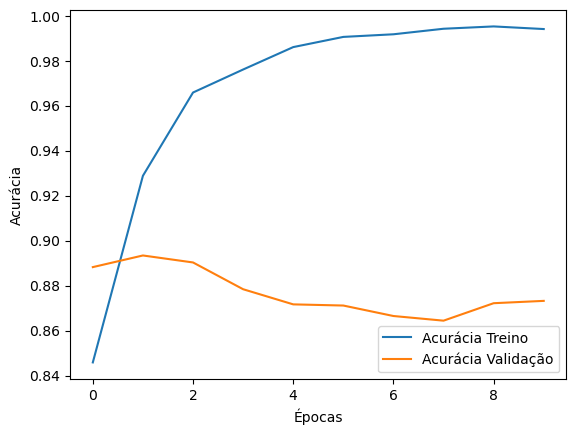

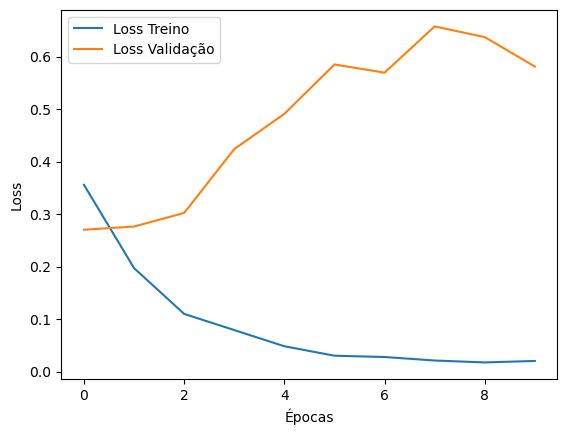

In [102]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar o loss
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
# Treinar o modelo
history = model.fit(
    train_review,       # Dados de entrada de treinamento (brutos, como strings)
    train_labels,       # Rótulos correspondentes aos dados de treinamento
    epochs=10,          # Número de épocas (pode ajustar conforme necessário)
    batch_size=32,      # Tamanho do lote (pode ajustar conforme necessário)
    validation_data=(test_review, test_labels),  # Dados de validação (brutos, como strings)
    verbose=1           # Nível de verbosidade (1 para ver o progresso do treinamento)
)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.7976 - loss: 0.4503 - val_accuracy: 0.8892 - val_loss: 0.2683
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.9357 - loss: 0.1786 - val_accuracy: 0.8975 - val_loss: 0.2599
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.9642 - loss: 0.1135 - val_accuracy: 0.8866 - val_loss: 0.2982
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.9753 - loss: 0.0795 - val_accuracy: 0.8882 - val_loss: 0.3664
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.9893 - loss: 0.0403 - val_accuracy: 0.8716 - val_loss: 0.5648
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.9909 - loss: 0.0308 - val_accuracy: 0.8665 - val_loss: 0.5423
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.9944 - loss: 0.0187 - val_accuracy: 0.8566 - val_loss: 0.7804
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.9927 - loss: 0.

In [90]:
test_loss, test_accuracy = model.evaluate(test_review, test_labels)
print(f"Loss no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4%}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8673 - loss: 0.6012
Loss no conjunto de teste: 0.5984
Acurácia no conjunto de teste: 86.5942%


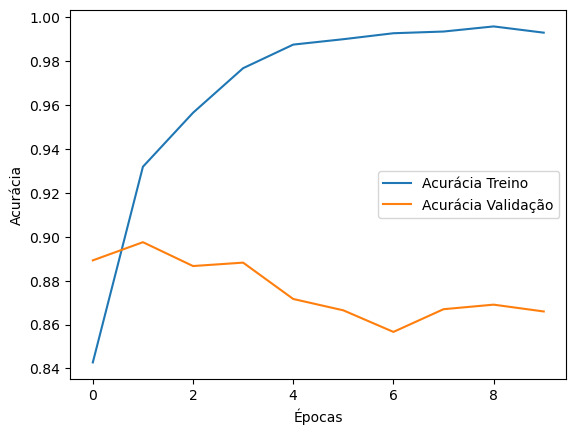

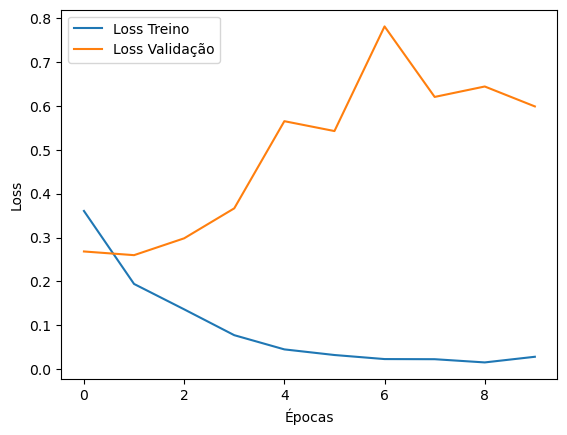

In [91]:
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar o loss
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()